## Importa bibliotecas

In [127]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_validate
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GroupKFold, GridSearchCV, cross_val_score, KFold

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

from sklearn.tree import export_graphviz
import graphviz

from sklearn.metrics import accuracy_score

## Carrega dados

In [2]:
uri = "https://gist.githubusercontent.com/guilhermesilveira/e99a526b2e7ccc6c3b70f53db43a87d2/raw/1605fc74aa778066bf2e6695e24d53cf65f2f447/machine-learning-carros-simulacao.csv"

dados = pd.read_csv(uri).drop(columns=["Unnamed: 0"], axis=1)

dados.head()

,preco,vendido,idade_do_modelo,km_por_ano
0,30941.02,1,18,35085.22134
1,40557.96,1,20,12622.05362
2,89627.50,0,12,11440.79806
3,95276.14,0,3,43167.32682
4,117384.68,1,4,12770.11290


In [3]:
# situação horrível de "azar" onde as classes estão ordenadas por padrão
dados_azar = dados.sort_values("vendido", ascending=True)
x_azar = dados_azar[["preco", "idade_do_modelo","km_por_ano"]]
y_azar = dados_azar["vendido"]
dados_azar.head()

,preco,vendido,idade_do_modelo,km_por_ano
4999,74023.29,0,12,24812.80412
5322,84843.49,0,13,23095.63834
5319,83100.27,0,19,36240.72746
5316,87932.13,0,16,32249.56426
5315,77937.01,0,15,28414.50704


In [5]:

SEED = 301
np.random.seed(SEED)

modelo = DummyClassifier()
results = cross_validate(modelo, x_azar, y_azar, cv = 10, return_train_score=False)
media = results['test_score'].mean()
desvio_padrao = results['test_score'].std()

print("Accuracy com dummy stratified, 10 = [%.2f, %.2f]" % ((media - 2 * desvio_padrao)*100, (media + 2 * desvio_padrao) * 100))


Accuracy com dummy stratified, 10 = [49.79, 53.45]


In [8]:
SEED = 301
np.random.seed(SEED)

modelo = DecisionTreeClassifier(max_depth=2)
results = cross_validate(modelo, x_azar, y_azar, cv = 10, return_train_score=False)
media = results['test_score'].mean()
desvio_padrao = results['test_score'].std()
print("Accuracy com cross validation, 10 = [%.2f, %.2f]" % ((media - 2 * desvio_padrao)*100, (media + 2 * desvio_padrao) * 100))


Accuracy com cross validation, 10 = [73.83, 77.73]


In [9]:
# gerando dados aleatórios de modelo de carro para simulação de agrupamento ao usar nosso estimador

np.random.seed(SEED)
dados['modelo'] = dados.idade_do_modelo + np.random.randint(-2, 3, size=10000)
dados.modelo = dados.modelo + abs(dados.modelo.min()) + 1
dados.head()


,preco,vendido,idade_do_modelo,km_por_ano,modelo
0,30941.02,1,18,35085.22134,18
1,40557.96,1,20,12622.05362,24
2,89627.50,0,12,11440.79806,14
3,95276.14,0,3,43167.32682,6
4,117384.68,1,4,12770.11290,5


In [10]:
def imprime_resultados(results):
    media = results['test_score'].mean() * 100
    desvio = results['test_score'].std() * 100
    print("Accuracy médio %.2f" % media)
    print("Intervalo [%.2f, %.2f]" % (media - 2 * desvio, media + 2 * desvio))
    

In [12]:
# GroupKFold para analisar como o modelo se comporta com novos grupos

SEED = 301
np.random.seed(SEED)

cv = GroupKFold(n_splits = 10)
modelo = DecisionTreeClassifier(max_depth=2)
results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=False)
imprime_resultados(results)

Accuracy médio 75.78
Intervalo [73.67, 77.90]


In [18]:
SEED = 301
np.random.seed(SEED)

scaler = StandardScaler()
modelo = SVC()

pipeline = Pipeline([('transformacao',scaler), ('estimador',modelo)])

cv = GroupKFold(n_splits = 10)
results = cross_validate(pipeline, x_azar, y_azar, 
                         cv = cv, groups = dados.modelo, 
                         return_train_score=False)
imprime_resultados(results)


/Users/luanandrade/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/luanandrade/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/luanandrade/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/luanandrade/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/luanandrade/anaconda3/lib/python3.7/site-packages/sklearn/base.py:4

Accuracy médio 76.68
Intervalo [74.28, 79.08]


/Users/luanandrade/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


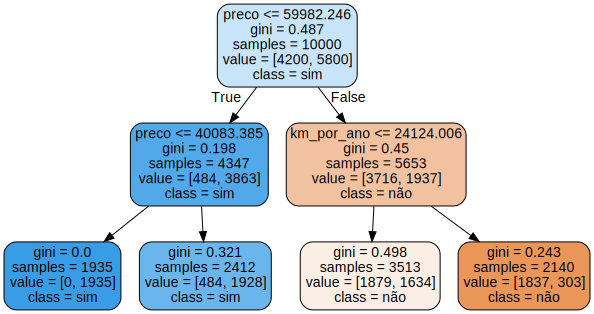

In [31]:
modelo = DecisionTreeClassifier(max_depth=2)
modelo.fit(x_azar, y_azar)

features = x_azar.columns
dot_data = export_graphviz(modelo, out_file=None, filled=True, 
                           rounded=True, 
                class_names=["não", "sim"], 
                feature_names =  features)

graph = graphviz.Source(dot_data)
graph

In [35]:
SEED = 301
np.random.seed(SEED)

cv = GroupKFold(n_splits = 10)
modelo = DecisionTreeClassifier(max_depth=2)
results = cross_validate(modelo, x_azar, y_azar, cv = cv, 
                         groups = dados.modelo, 
                         return_train_score=False)
imprime_resultados(results)

Accuracy médio 75.78
Intervalo [73.67, 77.90]


Tenta com max_deph =3 

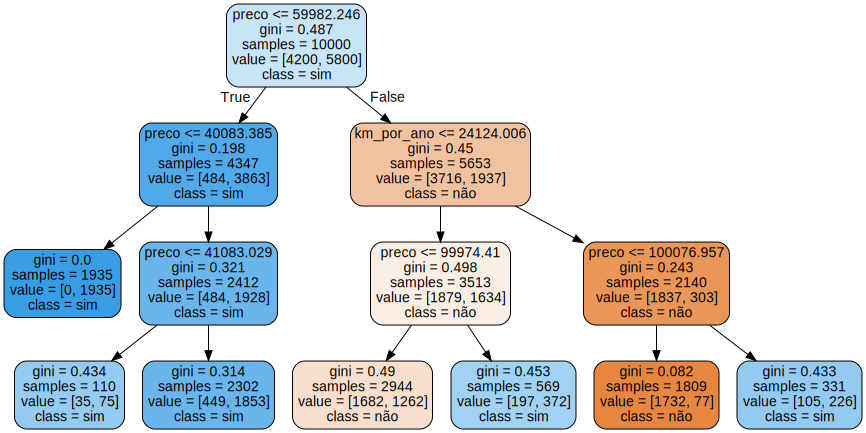

In [33]:

modelo = DecisionTreeClassifier(max_depth=3)
modelo.fit(x_azar, y_azar)

features = x_azar.columns
dot_data = export_graphviz(modelo, out_file=None, filled=True, 
                           rounded=True, 
                class_names=["não", "sim"], 
                feature_names =  features)

graph = graphviz.Source(dot_data)
graph

In [34]:
SEED = 301
np.random.seed(SEED)

cv = GroupKFold(n_splits = 10)
modelo = DecisionTreeClassifier(max_depth=3)
results = cross_validate(modelo, x_azar, y_azar, cv = cv, 
                         groups = dados.modelo, 
                         return_train_score=False)
imprime_resultados(results)

Accuracy médio 78.67
Intervalo [76.40, 80.94]


Max_deph=10

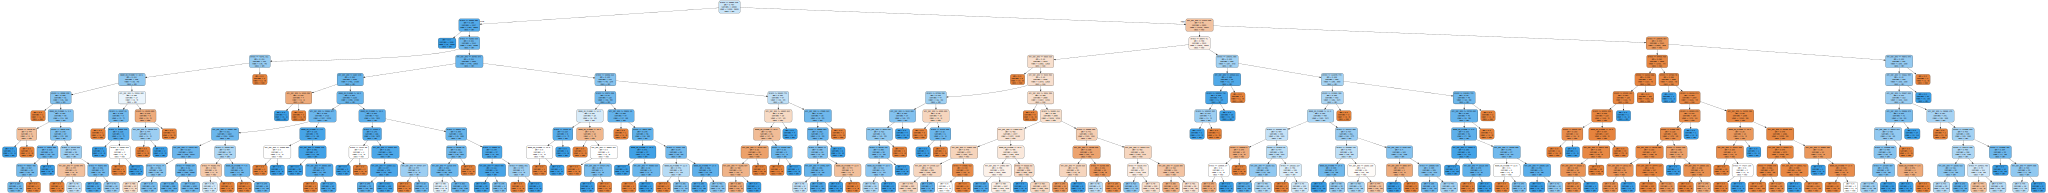

In [36]:

modelo = DecisionTreeClassifier(max_depth=10)
modelo.fit(x_azar, y_azar)

features = x_azar.columns
dot_data = export_graphviz(modelo, out_file=None, filled=True, 
                           rounded=True, 
                class_names=["não", "sim"], 
                feature_names =  features)

graph = graphviz.Source(dot_data)
graph

In [37]:
SEED = 301
np.random.seed(SEED)

cv = GroupKFold(n_splits = 10)
modelo = DecisionTreeClassifier(max_depth=10)
results = cross_validate(modelo, x_azar, y_azar, cv = cv, 
                         groups = dados.modelo, 
                         return_train_score=False)
imprime_resultados(results)

Accuracy médio 77.19
Intervalo [75.26, 79.13]


Testando parametros

In [65]:
def roda_arvode_de_decisao(max_depth):
    SEED = 301
    np.random.seed(SEED)

    cv = GroupKFold(n_splits = 10)
    modelo = DecisionTreeClassifier(max_depth=max_depth)
    results = cross_validate(modelo, x_azar, y_azar, cv = cv, 
                             groups = dados.modelo, 
                             return_train_score=True)
    
    train_score = results['train_score'].mean() * 100
    test_score = results['test_score'].mean() * 100
    
#     print("Max_depth: {}. Media teste {:.2f}. Media treino {:.2f}".format(
#         max_depth, 
#         test_score,
#         train_score)
    return [max_depth, train_score, test_score]

In [67]:
resultados = [roda_arvode_de_decisao(i) for i in range(1, 33)]
resultados = pd.DataFrame(resultados, columns=["max_depth", "train", "test"])
resultados.head()

,max_depth,train,test
0,1,75.791169,75.784219
1,2,75.791169,75.784219
2,3,78.750993,78.672633
3,4,78.787628,78.632803
4,5,78.941007,78.555912


## Overfit
Perfeito demais para o treino mas ruim para o teste

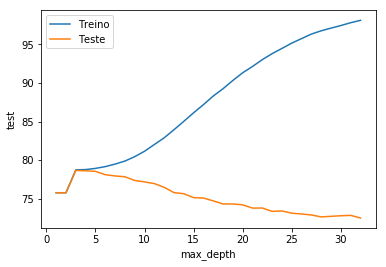

In [74]:
sns.lineplot(x = "max_depth", y = "train", data=resultados)
sns.lineplot(x = "max_depth", y = "test", data=resultados)
plt.legend(["Treino", "Teste"])

In [75]:
resultados.sort_values("test", ascending=False).head()

,max_depth,train,test
2,3,78.750993,78.672633
3,4,78.787628,78.632803
4,5,78.941007,78.555912
5,6,79.170115,78.123266
6,7,79.496806,77.963185


## Explorando hiper parametros em 2 dimensoes

In [76]:
def roda_arvode_de_decisao(max_depth, min_samples_leaf):
    SEED = 301
    np.random.seed(SEED)

    cv = GroupKFold(n_splits = 10)
    modelo = DecisionTreeClassifier(max_depth=max_depth,
                                    min_samples_leaf = min_samples_leaf)
    results = cross_validate(modelo, x_azar, y_azar, cv = cv, 
                             groups = dados.modelo, 
                             return_train_score=True)
    
    train_score = results['train_score'].mean() * 100
    test_score = results['test_score'].mean() * 100
    
    return [max_depth, min_samples_leaf, train_score, test_score]

In [80]:
def busca():
    resultados = []
    for depth in range(1, 33):
        for leaf in range(1, 33):
            tabela = roda_arvode_de_decisao(depth, leaf)
            resultados.append(tabela)
    return resultados
columns = ["max_depth", "min_samples_leaf", "train", "test"]
resultados = pd.DataFrame(busca(), columns = columns)
resultados

,max_depth,min_samples_leaf,train,test
0,1,1,75.791169,75.784219
1,1,2,75.791169,75.784219
2,1,3,75.791169,75.784219
3,1,4,75.791169,75.784219
4,1,5,75.791169,75.784219
5,1,6,75.791169,75.784219
6,1,7,75.791169,75.784219
7,1,8,75.791169,75.784219
8,1,9,75.791169,75.784219
9,1,10,75.791169,75.784219


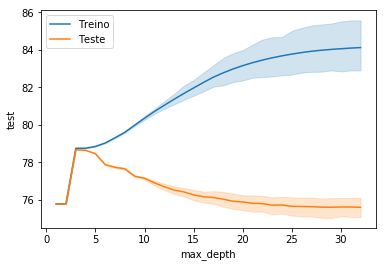

In [81]:
sns.lineplot(x = "max_depth", y = "train", data=resultados)
sns.lineplot(x = "max_depth", y = "test", data=resultados)
plt.legend(["Treino", "Teste"])

In [82]:
resultados.sort_values("test", ascending=False).head()

,max_depth,min_samples_leaf,train,test
123,4,28,78.750993,78.672633
126,4,31,78.750993,78.672633
85,3,22,78.750993,78.672633
84,3,21,78.750993,78.672633
83,3,20,78.750993,78.672633


In [84]:
corr = resultados.corr()
corr 

,max_depth,min_samples_leaf,train,test
max_depth,1.000000,0.000000,0.681408,-0.522835
min_samples_leaf,0.000000,1.000000,-0.453825,0.528330
train,0.681408,-0.453825,1.000000,-0.762534
test,-0.522835,0.528330,-0.762534,1.000000


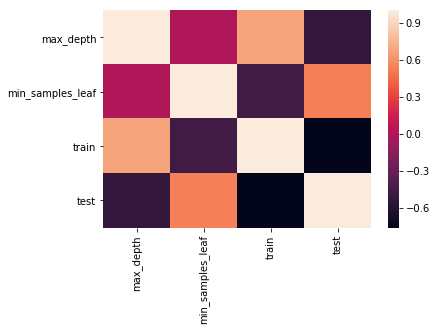

In [85]:
sns.heatmap(corr)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1305b08d0>,
      dtype=object)

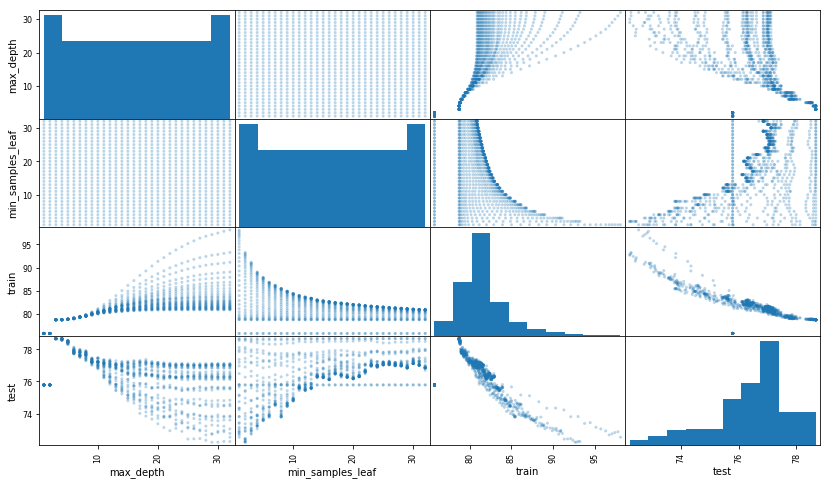

In [90]:
pd.plotting.scatter_matrix(resultados, figsize=(14,8), alpha=0.3)

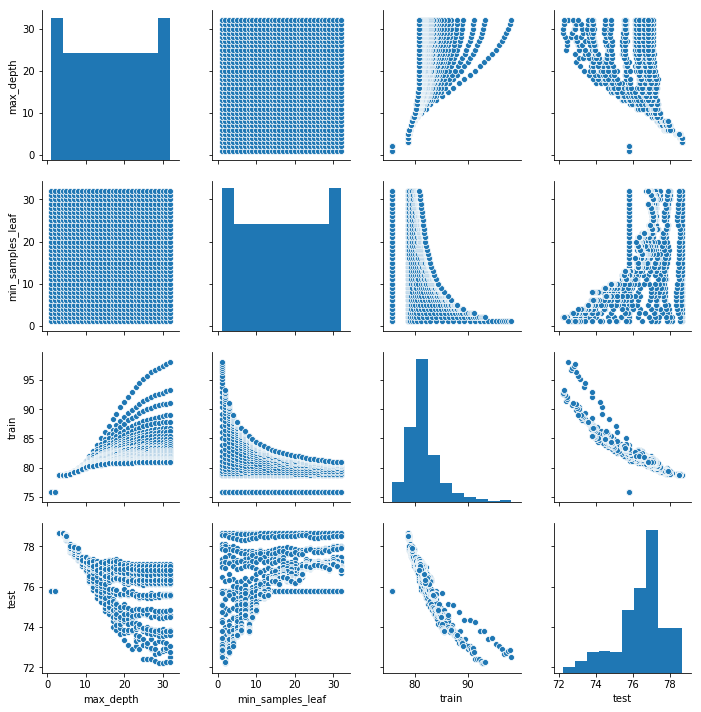

In [91]:
sns.pairplot(resultados)

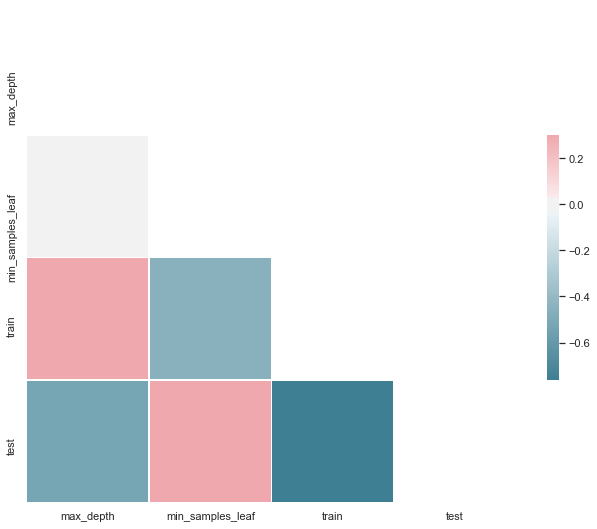

In [92]:
sns.set(style="white")

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [94]:
def busca():
    resultados = []
    for depth in range(1, 33):
        for leaf in [128, 192, 256, 512]:
            tabela = roda_arvode_de_decisao(depth, leaf)
            resultados.append(tabela)
    return resultados
columns = ["max_depth", "min_samples_leaf", "train", "test"]
resultados = pd.DataFrame(busca(), columns = columns)
resultados

,max_depth,min_samples_leaf,train,test
0,1,128,75.791169,75.784219
1,1,192,75.791169,75.784219
2,1,256,75.791169,75.784219
3,1,512,75.791169,75.784219
4,2,128,75.791169,75.784219
5,2,192,75.791169,75.784219
6,2,256,75.791169,75.784219
7,2,512,75.791169,75.784219
8,3,128,78.750993,78.672633
9,3,192,78.750993,78.672633


In [95]:
corr = resultados.corr()
corr 

,max_depth,min_samples_leaf,train,test
max_depth,1.000000,0.000000,0.354588,0.240852
min_samples_leaf,0.000000,1.000000,-0.637649,-0.440661
train,0.354588,-0.637649,1.000000,0.909222
test,0.240852,-0.440661,0.909222,1.000000


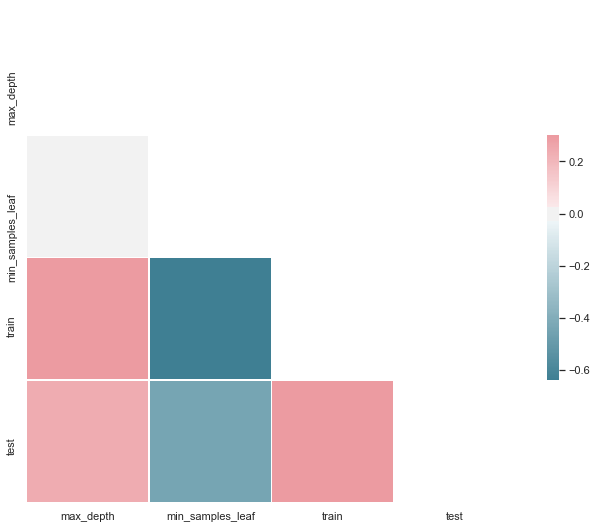

In [96]:
sns.set(style="white")

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


In [97]:
resultados.sort_values("test", ascending=False).head()

,max_depth,min_samples_leaf,train,test
13,4,192,78.750993,78.672633
8,3,128,78.750993,78.672633
9,3,192,78.750993,78.672633
10,3,256,78.750993,78.672633
14,4,256,78.750993,78.672633


## Explora 3 dimensões de hiper parâmetros

In [105]:
def roda_arvode_de_decisao(max_depth, min_samples_leaf, min_samples_split):
    SEED = 301
    np.random.seed(SEED)

    cv = GroupKFold(n_splits = 10)
    modelo = DecisionTreeClassifier(max_depth = max_depth,
                                    min_samples_leaf = min_samples_leaf,
                                    min_samples_split = min_samples_split)
    results = cross_validate(modelo, x_azar, y_azar, cv = cv, 
                             groups = dados.modelo, 
                             return_train_score=True)
    
    train_score = results['train_score'].mean() * 100
    test_score = results['test_score'].mean() * 100
    fit_time = results['fit_time'].mean()
    score_time = results['score_time'].mean()
    
    return [max_depth, min_samples_leaf, min_samples_split, 
            train_score, test_score, fit_time, score_time]

In [106]:
def busca():
    resultados = []
    for depth in range(1, 33):
        for leaf in [128, 192, 256, 512]:
            for min_split in [32, 64, 128, 256]:
                tabela = roda_arvode_de_decisao(depth, leaf, min_split)
                resultados.append(tabela)
    return resultados

columns = ["max_depth", "min_samples_leaf", "min_samples_split",
           "train", "test", "fit_time", "score_time"]
resultados = pd.DataFrame(busca(), columns = columns)
resultados

,max_depth,min_samples_leaf,min_samples_split,train,test,fit_time,score_time
0,1,128,32,75.791169,75.784219,0.005251,0.001207
1,1,128,64,75.791169,75.784219,0.004459,0.000961
2,1,128,128,75.791169,75.784219,0.003799,0.000812
3,1,128,256,75.791169,75.784219,0.003692,0.000819
4,1,192,32,75.791169,75.784219,0.003622,0.000770
5,1,192,64,75.791169,75.784219,0.003632,0.000765
6,1,192,128,75.791169,75.784219,0.003709,0.000793
7,1,192,256,75.791169,75.784219,0.003594,0.000759
8,1,256,32,75.791169,75.784219,0.003639,0.000762
9,1,256,64,75.791169,75.784219,0.003684,0.000784


In [107]:
corr = resultados.corr()
corr 

,max_depth,min_samples_leaf,min_samples_split,train,test,fit_time,score_time
max_depth,1.000000,0.000000,0.000000,0.354588,0.240852,0.444555,0.172513
min_samples_leaf,0.000000,1.000000,0.000000,-0.637649,-0.440661,-0.606326,-0.369080
min_samples_split,0.000000,0.000000,1.000000,0.000000,0.000000,0.006266,0.035031
train,0.354588,-0.637649,0.000000,1.000000,0.909222,0.908291,0.607489
test,0.240852,-0.440661,0.000000,0.909222,1.000000,0.777221,0.616992
fit_time,0.444555,-0.606326,0.006266,0.908291,0.777221,1.000000,0.635961
score_time,0.172513,-0.369080,0.035031,0.607489,0.616992,0.635961,1.000000


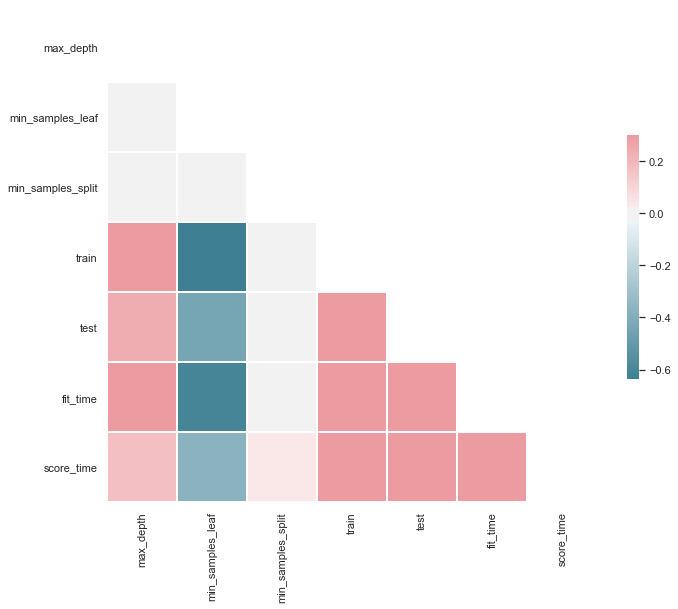

In [108]:
sns.set(style="white")

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [109]:
resultados.sort_values("test", ascending=False).head()

,max_depth,min_samples_leaf,min_samples_split,train,test,fit_time,score_time
54,4,192,128,78.750993,78.672633,0.009361,0.001102
55,4,192,256,78.750993,78.672633,0.009623,0.001101
32,3,128,32,78.750993,78.672633,0.008045,0.001022
33,3,128,64,78.750993,78.672633,0.007597,0.000955
34,3,128,128,78.750993,78.672633,0.008234,0.001082


## Explorando espaço de hiper parâmetros com GridSearchCV

In [112]:
SEED = 301
np.random.seed(SEED)

espaco_de_parametros = {
    "max_depth": [3, 5],
    "min_samples_split": [32, 64, 128],
    "min_samples_leaf": [32, 64, 128],
    "criterion": ["gini", "entropy"]
}

busca = GridSearchCV(DecisionTreeClassifier(),
                    espaco_de_parametros,
                    cv = GroupKFold(n_splits = 10))

busca.fit(x_azar, y_azar, groups = dados.modelo)
resultados = pd.DataFrame(busca.cv_results_)
resultados

/Users/luanandrade/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/luanandrade/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/luanandrade/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/luanan

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.008818,0.000721,0.001194,0.000158,gini,3,32,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.786863,0.787882,0.787862,0.786349,0.790210,0.788124,0.788803,0.786834,0.787510,0.001303
1,0.007026,0.000316,0.000872,0.000060,gini,3,32,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.786863,0.787882,0.787862,0.786349,0.790210,0.788124,0.788803,0.786834,0.787510,0.001303
2,0.006836,0.000064,0.000798,0.000021,gini,3,32,128,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.786863,0.787882,0.787862,0.786349,0.790210,0.788124,0.788803,0.786834,0.787510,0.001303
3,0.006784,0.000085,0.000781,0.000013,gini,3,64,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.786863,0.787882,0.787862,0.786349,0.790210,0.788124,0.788803,0.786834,0.787510,0.001303
4,0.006690,0.000066,0.000766,0.000014,gini,3,64,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.786863,0.787882,0.787862,0.786349,0.790210,0.788124,0.788803,0.786834,0.787510,0.001303
5,0.006678,0.000054,0.000761,0.000008,gini,3,64,128,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.786863,0.787882,0.787862,0.786349,0.790210,0.788124,0.788803,0.786834,0.787510,0.001303
6,0.006720,0.000238,0.000818,0.000108,gini,3,128,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.786863,0.787882,0.787862,0.786349,0.790210,0.788124,0.788803,0.786834,0.787510,0.001303
7,0.006741,0.000028,0.000796,0.000012,gini,3,128,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.786863,0.787882,0.787862,0.786349,0.790210,0.788124,0.788803,0.786834,0.787510,0.001303
8,0.006696,0.000159,0.000774,0.000016,gini,3,128,128,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.786863,0.787882,0.787862,0.786349,0.790210,0.788124,0.788803,0.786834,0.787510,0.001303
9,0.009328,0.000345,0.000796,0.000063,gini,5,32,32,"{'criterion': 'gini', 'max_depth': 5, 'min_sam...",0.804757,...,0.786863,0.788883,0.789304,0.786349,0.791542,0.788679,0.788803,0.788065,0.788166,0.001642


In [113]:
busca.best_params_

{'criterion': 'gini',
 'max_depth': 3,
 'min_samples_leaf': 32,
 'min_samples_split': 32}

In [115]:
busca.best_score_ * 100

78.68

In [116]:
melhor = busca.best_estimator_
melhor

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=32, min_samples_split=32,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [120]:
# evitar essa abordagem pois é muito otimista
predictions = melhor.predict(x_azar)
accuracy = accuracy_score(predictions, y_azar)
accuracy * 100

78.75

## Como ter uma estimativa sem vício dos dados que ja viu?

No caso de cross validation com busca de hiper parâmetros, fazemos uma nova validação cruzada. Chama-se Nested Cross Validation

In [123]:
scores = cross_val_score(busca, x_azar, y_azar, 
                         cv =  GroupKFold(n_splits = 10),
                         groups = dados.modelo)

scores

/Users/luanandrade/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:542: FutureWarning: From version 0.22, errors during fit will result in a cross validation score of NaN by default. Use error_score='raise' if you want an exception raised or error_score=np.nan to adopt the behavior from version 0.22.
  FutureWarning)


ValueError: The 'groups' parameter should not be None.

Como o Pandas não suporta nested validation com group K fold não conseguimos prever o resultado para novos grupos. (há um bug aberto para esse problema)

In [128]:
SEED = 301
np.random.seed(SEED)

espaco_de_parametros = {
    "max_depth": [3, 5],
    "min_samples_split": [32, 64, 128],
    "min_samples_leaf": [32, 64, 128],
    "criterion": ["gini", "entropy"]
}

busca = GridSearchCV(DecisionTreeClassifier(),
                    espaco_de_parametros,
                    cv = KFold(n_splits = 5, shuffle = True))

busca.fit(x_azar, y_azar, groups = dados.modelo)
resultados = pd.DataFrame(busca.cv_results_)
resultados

/Users/luanandrade/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/luanandrade/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/luanandrade/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/luanan

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.008922,0.000320,0.001506,0.000108,gini,3,32,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,...,0.7870,0.009618,1,0.788375,0.790125,0.783625,0.786,0.789500,0.787525,0.002405
1,0.008147,0.000325,0.001384,0.000298,gini,3,32,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,...,0.7870,0.009618,1,0.788375,0.790125,0.783625,0.786,0.789500,0.787525,0.002405
2,0.007426,0.000220,0.001161,0.000124,gini,3,32,128,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,...,0.7870,0.009618,1,0.788375,0.790125,0.783625,0.786,0.789500,0.787525,0.002405
3,0.007383,0.000165,0.001131,0.000192,gini,3,64,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,...,0.7870,0.009618,1,0.788375,0.790125,0.783625,0.786,0.789500,0.787525,0.002405
4,0.006861,0.000469,0.001031,0.000106,gini,3,64,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,...,0.7870,0.009618,1,0.788375,0.790125,0.783625,0.786,0.789500,0.787525,0.002405
5,0.006822,0.000314,0.001027,0.000087,gini,3,64,128,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,...,0.7870,0.009618,1,0.788375,0.790125,0.783625,0.786,0.789500,0.787525,0.002405
6,0.006272,0.000146,0.000983,0.000084,gini,3,128,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,...,0.7870,0.009618,1,0.788375,0.790125,0.783625,0.786,0.789500,0.787525,0.002405
7,0.006463,0.000236,0.000964,0.000095,gini,3,128,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,...,0.7870,0.009618,1,0.788375,0.790125,0.783625,0.786,0.789500,0.787525,0.002405
8,0.006259,0.000074,0.000950,0.000083,gini,3,128,128,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,...,0.7870,0.009618,1,0.788375,0.790125,0.783625,0.786,0.789500,0.787525,0.002405
9,0.008620,0.000098,0.001021,0.000092,gini,5,32,32,"{'criterion': 'gini', 'max_depth': 5, 'min_sam...",0.784,...,0.7831,0.010763,35,0.788375,0.790500,0.785500,0.786,0.791625,0.788400,0.002408


In [129]:
scores = cross_val_score(busca, x_azar, y_azar, 
                         cv = KFold(n_splits = 5, shuffle = True),
                         groups = dados.modelo)

scores

array([0.7895, 0.7825, 0.7905, 0.7715, 0.7995])

In [133]:
def imprime_score(scores):
    media = scores.mean() * 100
    desvio = scores.std() * 100
    print("Accuracy media = {:.2f}".format(media))
    print("Intervalo [{:.2f}, {:.2f}]".format(media - 2 * desvio, media + 2 * desvio))

In [134]:
imprime_score(scores)

Accuracy media = 78.67
Intervalo [76.80, 80.54]


In [136]:
melhor = busca.best_estimator_
melhor

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=32, min_samples_split=32,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

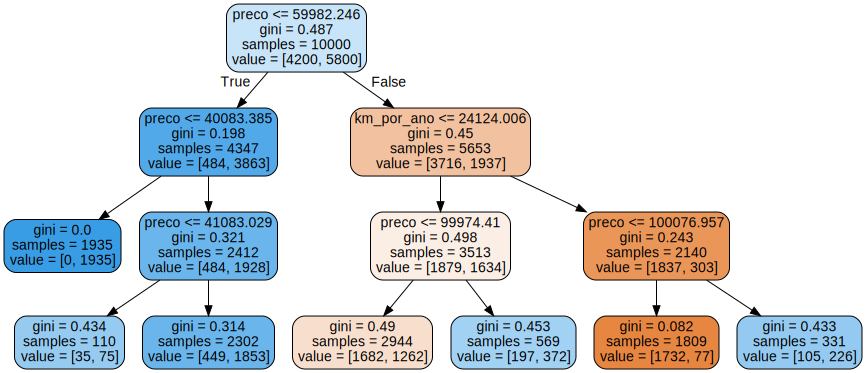

In [137]:
features = x_azar.columns
dot_data = export_graphviz(melhor, out_file=None, filled=True, 
                           rounded=True, feature_names = features)
graph = graphviz.Source(dot_data)
graph